# COMP7220 Individual Project
*By Jarred Reilly (43264204)*

## Project Description
This project will use the [ImageWoof dataset](https://github.com/fastai/imagenette#imagewoof), which is made up of 12,000 images of dogs divided into 10 classes (breeds). The goal is to classify images of dogs into the correct class with the accuracy metric being the measure of performance. To achieve this goal, a variety of conventional machine learning and deep learning techniques will be compared.

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
import keras
from keras.layers import Dropout, Flatten, Convolution2D, ZeroPadding2D, MaxPooling2D, Dense
from keras.models import Sequential
from keras.preprocessing import image
from PIL import Image

## Loading data
The following funciton, data_loader(), is used to load and preprocess the ImageWoof dataset. The default train/test split for the dataset will be used.

In [4]:
def data_loader(base_path, for_sklearn=False):
    """Loads the train and test sets of the Imagewoof dataset

    Args:
        base_path: A string providing the base path for the dataset
        for_sklearn: A boolean for whether to format the data for sklearn models

    Returns:
        Numpy arrays for the train and test sets plus the classes of the label encoder
    """

    def flatten_data(data):
        """Flattens the dimensions of the data for sklearn models

        Args:
            data: A multi-dimensional numpy array of image pixels to be flattened

        Returns:
            Data reshaped into one dimension
        """
        samples, dim1, dim2, alpha = data.shape
        data = data.reshape(samples, dim1 * dim2 * alpha)
        return data

    def load_image(image_path):
        """Loads an image from file and scales it

        Args:
            image_path: The path of the image on disk

        Returns:
            A numpy array of pixel values representing the image
        """
        img = image.load_img(image_path, grayscale=False, target_size=(img_dim, img_dim))
        x = image.img_to_array(img, dtype='float32')
        return x

    def load_dataset(breed_paths):
        """Loads all the images in a directory and normalizes them

        Args:
            breed_paths: A list of paths to the directories of each dog breed

        Returns:
            A numpy array of images in the dataset and a list of labels of the images in x
        """
        x = []
        y = []
        for i in range(num_classes):
            breed = breed_paths[i]
            breed_class = breed[-9:]
            image_paths = glob.glob(breed + '/*')
            for image_path in image_paths:
                x.append(load_image(image_path))
                y.append(breed_class)
        x = np.array(x)
        x /= 255
        return x, y

    print('Loading data...')
    train_paths = glob.glob(base_path + '/train/*')
    test_paths = glob.glob(base_path + '/val/*')
    x_train, y_train = load_dataset(train_paths)
    x_test, y_test = load_dataset(test_paths)
    if for_sklearn:
        x_train = flatten_data(x_train)
        x_test = flatten_data(x_test)
        encoder = LabelEncoder()
    else:
        encoder = LabelBinarizer()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    print('Finished loading data')
    return x_train, y_train, x_test, y_test, encoder.classes_

In [30]:
img_dim = 224
num_classes = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof')

Loading data...
Finished loading data


## Data Exploration
### Class Distribution

It's important to know the distribution of the classes to judge the accuracy of the models correctly. For example, if one class made up 90% of the images in the train and test sets, models trained on this data are not likely to perform as well on the other classes.

In [10]:
imagenet_classes = {
        'n02115641': 'Dingo',
        'n02111889': 'Samoyed',
        'n02105641': 'Old English Sheepdog',
        'n02099601': 'Golden Retriever',
        'n02096294': 'Australian Terrier',
        'n02093754': 'Border Terrier',
        'n02089973': 'English Foxhound',
        'n02088364': 'Beagle',
        'n02087394': 'Rhodesian Ridgeback',
        'n02086240': 'Shih-Tzu'
    }


def get_class(prediction, classes):
    """Gets the class name of a prediction or label

    Args:
        prediction: A one-hot numpy array
        classes: the classes from the encoder

    Returns:
        The English name of the prediction or label
    """
    return imagenet_classes[classes[np.argmax(prediction)]]


def class_distribution(labels, classes):
    """Prints the distribution of classes in a dataset
    
    Args:
        labels: the true labels for the data
        classes: the classes from the encoder
        
    Returns:
        Nothing
    """
    label_counts = {}
    for label in labels:
        class_name = get_class(label, classes)
        if class_name in label_counts:
            label_counts[class_name] += 1
        else:
            label_counts[class_name] = 1
    
    for dog_breed, count in label_counts.items():
        print(f'{dog_breed}: {count}')

In [13]:
print('Train distribution:')
class_distribution(y_train, encoder_classes)
print('\nTest distribution:')
class_distribution(y_test, encoder_classes)

Train distribution:
English Foxhound: 580
Shih-Tzu: 941
Old English Sheepdog: 928
Border Terrier: 949
Beagle: 932
Rhodesian Ridgeback: 942
Australian Terrier: 943
Samoyed: 921
Dingo: 940
Golden Retriever: 949

Test distribution:
English Foxhound: 224
Shih-Tzu: 409
Old English Sheepdog: 422
Border Terrier: 401
Beagle: 418
Rhodesian Ridgeback: 408
Australian Terrier: 407
Samoyed: 429
Dingo: 410
Golden Retriever: 401


**Distribution Results**

From the distribution analysis we can see that all the classes except the English Foxhound have approximately equal numbers of instances. The English foxhound has about 60% the amount of the other classes which is fine in this instance.

### Visualising Images

Visualising some of the images in the dataset will give us a feel for what our models will be working with and ensure we've encoded the images in the correct way.

In [38]:
def display_image(img):
    """Displays an array of pixels as an image

    Args:
        img: an array of pixels
    """
    restored_img = img * 255
    pil_img = Image.fromarray(restored_img.astype(np.uint8))
    plt.imshow(pil_img)

    
def plot_image(img, label):
    print(get_class(label, encoder_classes))
    display_image(img)

English Foxhound


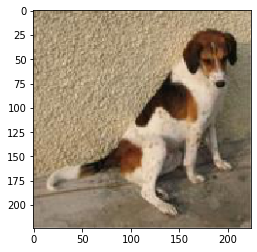

In [39]:
plot_image(x_train[0], y_train[0])

Shih-Tzu


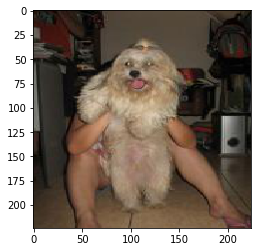

In [40]:
plot_image(x_train[1000], y_train[1000])

Old English Sheepdog


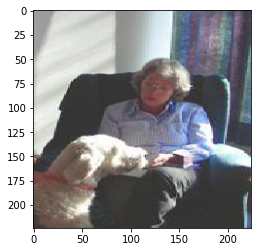

In [41]:
plot_image(x_train[2000], y_train[2000])

**Visualisation Results**

As we can see, the images are not just close up portraits of the dogs which are facing the camera. This dataset is quite messy and there's often people and other objects in the images. This is good because 

## Conventional Machine Learning
Many conventional machine learning techniques are not suitable for the extremely high dimensionality of image data. The image size that most testing will be done at is 224x224, which when we factor in the RGB channels will have 150,528 dimensions! The decision trees and k-nearest neighbors algorithms are particually not suitable because they work best with a small number of features which are highly relevant to classification. The only suitable options are logistic regression and support vector machines classifiers.

SKlearn models only allow for one dimesional input, so the images have to be specially preprocessed.

### First Attempt

In [ ]:
img_dim = 224
num_classes = 10

sx_train, sy_train, sx_test, sy_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=True)

In [43]:
def evaluate_model(model, x_train, y_train, x_test, y_test):
    """Trains a model and prints the train and test accuracy.

    Args:
        model: an sklearn model to be trained and evaluated
        x_train: train set of images
        y_train: labels of train set
        x_test: test set of images
        y_test: labels of test set

    Returns:
        The trained model
    """
    print('Training model...')
    model.fit(x_train, y_train)
    print('Evaluating model...')
    print(f'Train accuracy: {model.score(x_train, y_train)}')
    print(f'Test accuracy: {model.score(x_test, y_test)}')
    return model

In [ ]:
lr_model = LogisticRegression(max_iter=100)

print('Logistic Regression:')
evaluate_model(lr_model)

Training model...  
Evaluating model...  
Train accuracy: 0.545  
Test accuracy: 0.252

In [ ]:
svm_model = SGDClassifier()

print('SVM:')
evaluate_model(svm_model)

Training model...  
Evaluating model...  
Train accuracy: 0.865  
Test accuracy: 0.203

**First Attempt Results**

The 10 class classification has a random chance accuracy 0.1, so the models are learning something but the performance is very poor.

### Second Attempt
For the next test, the size of the images will be brought down to 48x48 and the number of classes to 4 to make the task as comparable to that of the main project as possible. The expecation is that the accuracy result will be about 0.8 for the test set.

In [ ]:
img_dim = 48
num_classes = 4

sx_train, sy_train, sx_test, sy_test, encoder_classes = data_loader('./data/imagewoof', for_sklearn=True)

In [ ]:
lr_model = LogisticRegression(max_iter=100)

print('Logistic Regression:')
evaluate_model(lr_model)

Training model...  
Evaluating model...  
Train accuracy: 0.813  
Test accuracy: 0.492

In [ ]:
svm_model = SGDClassifier()

print('SVM:')
evaluate_model(svm_model)

Training model...  
Evaluating model...  
Train accuracy: 0.906  
Test accuracy: 0.463

**Second Attempt Results**

There's a definite improvement in the test accuracy for both the logisitic regression and svm models, however there's a large gap between the train and test accuracy which indicates that the models are overfitting to the training data. The fact that the accuracy is still below 0.5 indicates that the classification of the dog breeds is more difficult than the hair colour classification task in the major project.

## Deep Learning
Deep learning is much better suited for image datasets and is therefore likely to perform much better.
Here is the model which performed the best on the CelebA dataset in the major project.

In [ ]:
def cnn(x_train, y_train, x_test, y_test):
    cnn_model = Sequential()
    cnn_model.add(ZeroPadding2D((1, 1), input_shape=(img_dim, img_dim, 3)))
    cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(32, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cnn_model.add(ZeroPadding2D((1, 1)))
    cnn_model.add(Convolution2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

    cnn_model.add(Dropout(0.5))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy']
                      )

    cnn_model.fit(x_train, y_train, epochs=epochs, batch_size=256)
    score = cnn_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [ ]:
img_dim = 224
num_classes = 10
epochs = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof')
cnn(x_train, y_train, x_test, y_test)

Test loss:  
Test accuracy:  

In [ ]:
img_dim = 224
num_classes = 4
epochs = 10
x_train, y_train, x_test, y_test, encoder_classes = data_loader('./data/imagewoof')
cnn(x_train, y_train, x_test, y_test)

Test loss:  
Test accuracy: 0.7